## Observed data, clustering with KMeans

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from kmeans import k_means
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "kmeans_observed_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning K-Means for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    for k in [3, 4, 5, 6, 7]:
        result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(
            k_means, "K-Means", normalized_data, data_min, data_max, k, plot=False
        )

        unnormalized_data, cluster_centers = unnormalize(result_kmeans.data, result_kmeans.cluster_centers, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, result_kmeans.labels, cluster_centers)
        plotter.clusters_2d_plot(f"K-Means: years = {year_range}, k = {k}", os.path.join(plot_dir, f"kmeans_{year_range}_k{k}.png"))

        results.append({
            "Year Range": year_range, "k": k, "Runtime (s)": f"{time_kmeans:.3f}", "Clusters": n_clusters_kmeans,
            "Points per Cluster": points_per_cluster_kmeans,
            "Davies-Bouldin": f"{metrics_kmeans[0]:.3f}" if metrics_kmeans else None,
            "Calinski-Harabasz": f"{metrics_kmeans[1]:.3f}" if metrics_kmeans else None,
            "Dunn Index": f"{metrics_kmeans[2]:.3f}" if metrics_kmeans else None,
            "Silhouette Score": f"{metrics_kmeans[3]:.3f}" if metrics_kmeans else None
        })
    
    display(pd.DataFrame(results))

## Observed data, clustering with DBSCAN

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from DBSCAN import dbscan_clustering  # Assuming you have a DBSCAN implementation
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "dbscan_observed_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning DBSCAN for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    eps_values = [0.02, 0.01, 0.015, 0.05]
    min_samples_values = [10, 15, 20, 25]
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )

            unnormalized_data, cluster_centers = unnormalize(result_dbscan.data, result_dbscan.cluster_centers, data_min, data_max)
            plotter = ClusterPlotter(unnormalized_data, result_dbscan.labels, cluster_centers)
            plotter.clusters_2d_plot(
                f"DBSCAN: years = {year_range}, eps = {eps}, min_samples = {min_samples}",
                os.path.join(plot_dir, f"dbscan_{year_range}_eps{eps}_min{min_samples}.png")
            )

            results.append({
                "Year Range": year_range, "eps": eps, "min_samples": min_samples, "Runtime (s)": f"{time_dbscan:.3f}",
                "Clusters": n_clusters_dbscan, "Points per Cluster": points_per_cluster_dbscan,
                "Davies-Bouldin": f"{metrics_dbscan[0]:.3f}" if metrics_dbscan else None,
                "Calinski-Harabasz": f"{metrics_dbscan[1]:.3f}" if metrics_dbscan else None,
                "Dunn Index": f"{metrics_dbscan[2]:.3f}" if metrics_dbscan else None,
                "Silhouette Score": f"{metrics_dbscan[3]:.3f}" if metrics_dbscan else None
            })
    
    display(pd.DataFrame(results))


## Observed data, clustering with DBSCAN with GridSearch

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from DBSCAN import dbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

plot_dir = "dbscan_grid_search_normal_bins_observed"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

results_per_year_range = {}

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # DBSCAN parameter grid
    eps_values = [0.01, 0.012, 0.015, 0.018, 0.02, 0.023, 0.05]
    min_samples_values = [7, 10, 15, 20, 30]
    
    best_result = None
    best_score = float('-inf')
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )
            
            silhouette_score = metrics_dbscan[3] if metrics_dbscan and isinstance(metrics_dbscan[3], (int, float)) else None
            noise_points = np.sum(result_dbscan.labels == -1)

            if silhouette_score is not None and silhouette_score > best_score:
                best_score = silhouette_score
                best_result = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "runtime": time_dbscan,
                    "clusters": n_clusters_dbscan,
                    "points_per_cluster": points_per_cluster_dbscan,
                    "noise_points": noise_points,
                    "metrics": metrics_dbscan,
                    "result_dbscan": result_dbscan
                }

    # Plot and store only the best result
    if best_result:
        unnormalized_data, _ = unnormalize(best_result["result_dbscan"].data, None, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, best_result["result_dbscan"].labels, None)
        plot_filename = os.path.join(plot_dir, f"dbscan_{year_range}_best.png")
        title = f"DBSCAN Best: {year_range}, eps = {best_result['eps']}, min_samples = {best_result['min_samples']}"
        plotter.clusters_2d_plot(title, plot_filename, show_centers=False)
        
        results_per_year_range[year_range] = best_result
        
        print(f"Best for {year_range}: eps = {best_result['eps']}, min_samples = {best_result['min_samples']}, silhouette = {best_score:.3f}")

final_results = [
    {"Year Range": yr, "Eps": res["eps"], "Min Samples": res["min_samples"], "Silhouette Score": f"{res['metrics'][3]:.3f}", "Noise Points": res["noise_points"]}
    for yr, res in results_per_year_range.items()
]
df = pd.DataFrame(final_results)
display(df)

## Observed data, clustering with OPTICS

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running OPTICS for Year Range: 2002-2005

OPTICS result:


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

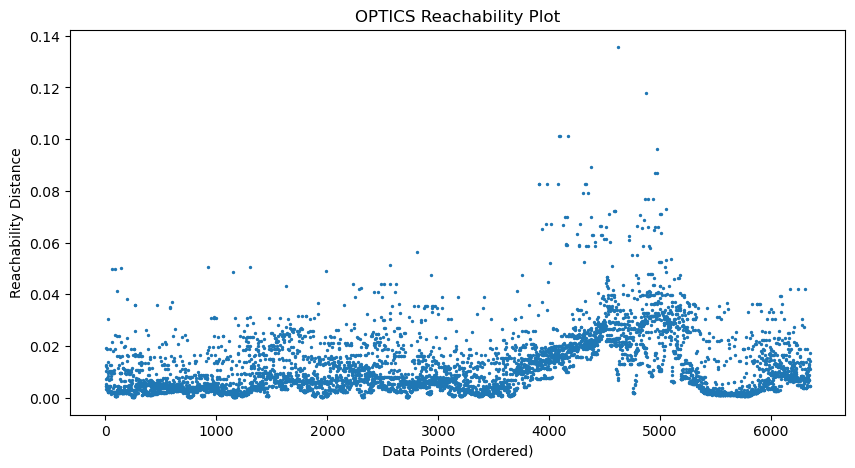

Running OPTICS:  33%|███▎      | 1/3 [00:04<00:09,  4.93s/step]

Runtime for optics_clustering: 4.932806 seconds


Running OPTICS: 100%|██████████| 3/3 [00:06<00:00,  2.03s/step]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min10000_maxepsinf_xi10000000.png

OPTICS result:


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

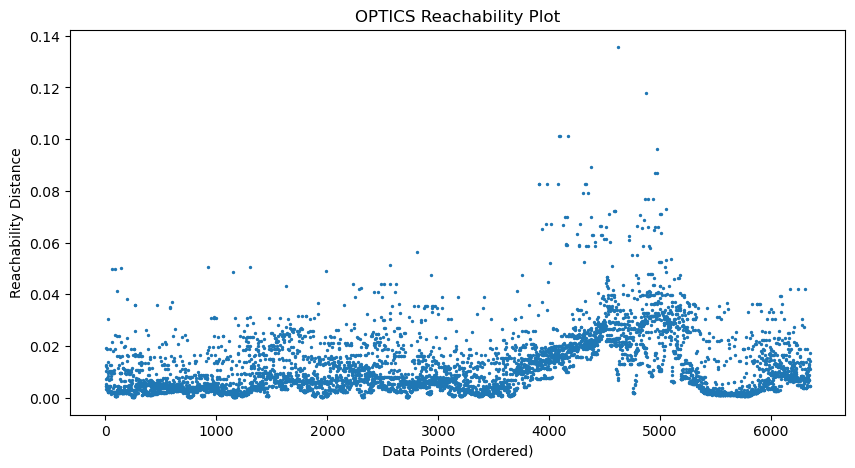

Running OPTICS:  33%|███▎      | 1/3 [00:04<00:09,  4.67s/step]

Runtime for optics_clustering: 4.667865 seconds


Running OPTICS: 100%|██████████| 3/3 [00:05<00:00,  1.88s/step]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min10000_maxepsinf_xi1.png

OPTICS result:


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

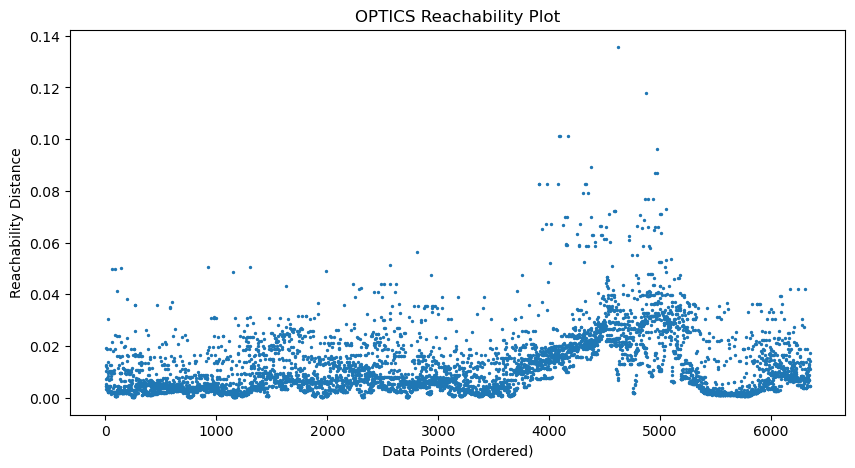

Running OPTICS:  33%|███▎      | 1/3 [00:04<00:09,  4.76s/step]

Runtime for optics_clustering: 4.761530 seconds


Running OPTICS: 100%|██████████| 3/3 [00:05<00:00,  2.00s/step]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min10000_maxepsinf_xi0.1.png

OPTICS result:


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

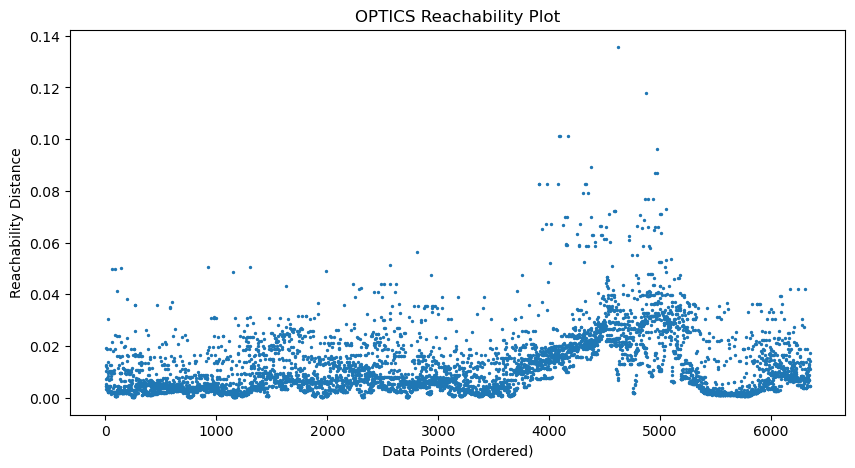

Running OPTICS:  33%|███▎      | 1/3 [00:05<00:11,  5.69s/step]

Runtime for optics_clustering: 5.692551 seconds


Running OPTICS: 100%|██████████| 3/3 [00:06<00:00,  2.29s/step]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min100_maxepsinf_xi10000000.png

OPTICS result:


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]


KeyboardInterrupt: 

In [1]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from OPTICS import optics_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

plot_dir = "Images/optics_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning OPTICS for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    min_samples_values = [10000, 100, 10]
    max_eps_vals = [np.inf]
    xi_vals = [10000000, 1, 0.1]

    results = []

    for min_sample in min_samples_values: 
        for max_eps in max_eps_vals:
            for xi in xi_vals:
                result_optics, time_optics, n_clusters_optics, points_per_cluster_optics, metrics_optics = run_clustering(
                    optics_clustering, "OPTICS", normalized_data, data_min, data_max, min_sample, max_eps, xi, plot_reachability = True, plot=False
                )

                unnormalized_data, cluster_centers = unnormalize(
                    result_optics.data, result_optics.cluster_centers, data_min, data_max
                )
                plotter = ClusterPlotter(unnormalized_data, result_optics.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"optics_{year_range}_min{min_sample}_maxeps{max_eps}_xi{xi}.png")
                title = f"OPTICS: years = {year_range}, min: {min_sample}, maxeps: {max_eps}, xi: {xi},"
                plotter.clusters_2d_plot(title, plot_filename)

                # Round metric results
                rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_optics[4].items()}
                rounded_square_density = {key: round(value, 3) for key, value in metrics_optics[5].items()}
                rounded_hull_density = {key: round(value, 3) for key, value in metrics_optics[6].items()}

                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_optics,
                    "Runtime (s)": f"{time_optics:.3f}",
                    "Clusters": n_clusters_optics,
                    "Points per Cluster": points_per_cluster_optics,
                    "Davies-Bouldin": f"{metrics_optics[0]:.3f}" if metrics_optics and isinstance(metrics_optics[0], (int, float)) else None,
                    "Calinski-Harabasz": f"{metrics_optics[1]:.3f}" if metrics_optics and isinstance(metrics_optics[1], (int, float)) else None,
                    "Dunn Index": f"{metrics_optics[2]:.3f}" if metrics_optics and isinstance(metrics_optics[2], (int, float)) else None,
                    "Silhouette Score": f"{metrics_optics[3]:.3f}" if metrics_optics and isinstance(metrics_optics[3], (int, float)) else None,
                    "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                    "Square Density": rounded_square_density if rounded_square_density else None,
                    "Hull Density": rounded_hull_density if rounded_hull_density else None
                })

    df = pd.DataFrame(results)
    display(df)

## Observed data, clustering with HDBSCAN

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from HDBSCAN import hdbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

results_per_year_range = {}

images_dir = "Images"
os.makedirs(images_dir, exist_ok=True)
plot_dir = os.path.join("Images", "hdbscan_observations_normal_bins")
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning HDBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    min_cluster_size_values = [100, 150, 180]  
    min_samples_values = [None, 5, 10] 
    cluster_selection_epsilon_values = [0.0, 0.01, 0.1] 

    results = []

    for min_cluster_size in min_cluster_size_values: 
        for min_samples in min_samples_values:
            for cluster_selection_epsilon in cluster_selection_epsilon_values:

                result_hdbscan, time_hdbscan, n_clusters_hdbscan, points_per_cluster_hdbscan, metrics_hdbscan = run_clustering(
                    hdbscan_clustering, "HDBSCAN", normalized_data, data_min, data_max, min_cluster_size, min_samples, cluster_selection_epsilon, plot_condensed_tree=True, plot=False
                )

                unnormalized_data, cluster_centers = unnormalize(
                    result_hdbscan.data, result_hdbscan.cluster_centers, data_min, data_max
                )
                plotter = ClusterPlotter(unnormalized_data, result_hdbscan.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"hdbscan_{year_range}_minclust{min_cluster_size}_minsamples{min_samples}_epsilon{cluster_selection_epsilon}.png")
                title = f"HDBSCAN: years = {year_range}, min_cluster_size: {min_cluster_size}, min_samples: {min_samples}, epsilon: {cluster_selection_epsilon},"
                plotter.clusters_2d_plot(title, plot_filename)

                rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_hdbscan[4].items()}
                rounded_square_density = {key: round(value, 3) for key, value in metrics_hdbscan[5].items()}
                rounded_hull_density = {key: round(value, 3) for key, value in metrics_hdbscan[6].items()}

                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_hdbscan,
                    "Runtime (s)": f"{time_hdbscan:.3f}",
                    "Clusters": n_clusters_hdbscan,
                    "Points per Cluster": points_per_cluster_hdbscan,
                    "Davies-Bouldin": f"{metrics_hdbscan[0]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[0], (int, float)) else None,
                    "Calinski-Harabasz": f"{metrics_hdbscan[1]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[1], (int, float)) else None,
                    "Dunn Index": f"{metrics_hdbscan[2]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[2], (int, float)) else None,
                    "Silhouette Score": f"{metrics_hdbscan[3]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[3], (int, float)) else None,
                    "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                    "Square Density": rounded_square_density if rounded_square_density else None,
                    "Hull Density": rounded_hull_density if rounded_hull_density else None
                })

    df = pd.DataFrame(results)
    display(df)

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running HDBSCAN for Year Range: 2002-2005

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/step]

Runtime for hdbscan_clustering: 1.495470 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.21step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamplesNone_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.60s/step]

Runtime for hdbscan_clustering: 1.601991 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.16step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamplesNone_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/step]

Runtime for hdbscan_clustering: 1.549643 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:03<00:00,  1.03s/step]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamplesNone_epsilon0.1.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:03<00:07,  3.75s/step]

Runtime for hdbscan_clustering: 3.754582 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:06<00:00,  2.12s/step]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamples5_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:04<00:08,  4.14s/step]

Runtime for hdbscan_clustering: 4.140529 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:06<00:00,  2.32s/step]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamples5_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:04<00:08,  4.11s/step]

Runtime for hdbscan_clustering: 4.112983 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:05<00:00,  1.71s/step]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamples5_epsilon0.1.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/step]

Runtime for hdbscan_clustering: 1.502083 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.21step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamples10_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.92s/step]

Runtime for hdbscan_clustering: 1.921177 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.03step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamples10_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/step]

Runtime for hdbscan_clustering: 1.634995 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.16step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust100_minsamples10_epsilon0.1.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/step]

Runtime for hdbscan_clustering: 1.811205 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.09step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamplesNone_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/step]

Runtime for hdbscan_clustering: 1.403942 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.28step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamplesNone_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/step]

Runtime for hdbscan_clustering: 1.381786 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.26step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamplesNone_epsilon0.1.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.87s/step]

Runtime for hdbscan_clustering: 1.866291 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.07step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamples5_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:03,  1.61s/step]

Runtime for hdbscan_clustering: 1.613288 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.16step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamples5_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/step]

Runtime for hdbscan_clustering: 1.449682 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.23step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamples5_epsilon0.1.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:02<00:04,  2.18s/step]

Runtime for hdbscan_clustering: 2.181825 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:03<00:00,  1.06s/step]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamples10_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/step]

Runtime for hdbscan_clustering: 1.394416 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.29step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamples10_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/step]

Runtime for hdbscan_clustering: 1.369775 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.27step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust150_minsamples10_epsilon0.1.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/step]

Runtime for hdbscan_clustering: 1.451016 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.24step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust180_minsamplesNone_epsilon0.0.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/step]

Runtime for hdbscan_clustering: 1.450556 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:02<00:00,  1.25step/s]


Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust180_minsamplesNone_epsilon0.01.png

HDBSCAN result:


Running HDBSCAN:  33%|███▎      | 1/3 [00:02<00:04,  2.29s/step]

Runtime for hdbscan_clustering: 2.287439 seconds


Running HDBSCAN: 100%|██████████| 3/3 [00:03<00:00,  1.09s/step]


KeyboardInterrupt: 

## Observed data, clustering with DENCLUE

In [1]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from clustering_utils import ClusteringResult
from scipy.spatial.distance import cdist
from DENCLUE import denclue_clustering  # Import DENCLUE clustering function
from cluster_plotter import ClusterPlotter

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

results_per_year_range = {}

plot_dir = "Images/denclue_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DENCLUE for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    epsilon_vals = [30, 40, 50]
    max_iter_vals = [100, 200, 300]
    bandwidth_vals = [0.005, 0.07, 0.01]

    results = []

    for epsilon in epsilon_vals:
        for max_iter in max_iter_vals:
            for bandwidth in bandwidth_vals:
                result_denclue, time_denclue, n_clusters_denclue, points_per_cluster_denclue, metrics_denclue = run_clustering(
                    denclue_clustering, "DENCLUE",
                    normalized_data, data_min, data_max, epsilon=epsilon, max_iter=max_iter, bandwidth=bandwidth, plot=False
                )
                if len(result_denclue.cluster_centers) > 0:
                    unnormalized_data, cluster_centers = unnormalize(
                        result_denclue.data, result_denclue.cluster_centers, data_min, data_max
                    )
                    plotter = ClusterPlotter(unnormalized_data, result_denclue.labels, None)
                    plot_filename = os.path.join(plot_dir, f"denclue_{year_range}_eps{epsilon}_maxiter{max_iter}_bandwidth{bandwidth}.png")
                    title = f"DENCLUE: years = {year_range}, epsilon: {epsilon}, max_iter: {max_iter}, bandwidth: {bandwidth}"
                    plotter.clusters_2d_plot(title, plot_filename, show_centers=False)
                    
                    rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_denclue[4].items()}
                    rounded_square_density = {key: round(value, 3) for key, value in metrics_denclue[5].items()}
                    rounded_hull_density = {key: round(value, 3) for key, value in metrics_denclue[6].items()}

                    results.append({
                        "Year Range": year_range,
                        "k": n_clusters_denclue,
                        "Runtime (s)": f"{time_denclue:.3f}",
                        "Clusters": n_clusters_denclue,
                        "Points per Cluster": points_per_cluster_denclue,
                        "Davies-Bouldin": f"{metrics_denclue[0]:.3f}" if metrics_denclue and isinstance(metrics_denclue[0], (int, float)) else None,
                        "Calinski-Harabasz": f"{metrics_denclue[1]:.3f}" if metrics_denclue and isinstance(metrics_denclue[1], (int, float)) else None,
                        "Dunn Index": f"{metrics_denclue[2]:.3f}" if metrics_denclue and isinstance(metrics_denclue[2], (int, float)) else None,
                        "Silhouette Score": f"{metrics_denclue[3]:.3f}" if metrics_denclue and isinstance(metrics_denclue[3], (int, float)) else None,
                        "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                        "Square Density": rounded_square_density if rounded_square_density else None,
                        "Hull Density": rounded_hull_density if rounded_hull_density else None
                    })
                else:
                    print(f"No clusters formed for epsilon={epsilon}, max_iter={max_iter}, bandwidth={bandwidth}. Skipping plotting and results.")
                    continue


    df = pd.DataFrame(results)
    display(df)

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running DENCLUE for Year Range: 2002-2005

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.13step/s]

Runtime for denclue_clustering: 0.881850 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.60step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.72step/s]

Runtime for denclue_clustering: 0.581096 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.87step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.34step/s]

Runtime for denclue_clustering: 0.748696 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.88step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:02,  1.34s/step]

Runtime for denclue_clustering: 1.337169 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:02<00:00,  1.37step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.81step/s]

Runtime for denclue_clustering: 0.551571 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.08step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.23step/s]

Runtime for denclue_clustering: 0.816137 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.85step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.20step/s]

Runtime for denclue_clustering: 0.833171 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.73step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.88step/s]

Runtime for denclue_clustering: 0.530816 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.08step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.33step/s]

Runtime for denclue_clustering: 0.751715 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.90step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps30_maxiter300_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.07step/s]

Runtime for denclue_clustering: 0.937628 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.62step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.68step/s]

Runtime for denclue_clustering: 0.596951 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.84step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.38step/s]

Runtime for denclue_clustering: 0.724044 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.83step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.15step/s]

Runtime for denclue_clustering: 0.865855 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.68step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.94step/s]

Runtime for denclue_clustering: 0.516629 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.11step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.29step/s]

Runtime for denclue_clustering: 0.775409 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.80step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.22step/s]

Runtime for denclue_clustering: 0.821593 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.75step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.95step/s]

Runtime for denclue_clustering: 0.514110 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.12step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.03step/s]

Runtime for denclue_clustering: 0.967360 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.70step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps40_maxiter300_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.18step/s]

Runtime for denclue_clustering: 0.847408 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.71step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.02step/s]

Runtime for denclue_clustering: 0.494496 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.89step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.44step/s]

Runtime for denclue_clustering: 0.692164 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.98step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.24step/s]

Runtime for denclue_clustering: 0.809556 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.71step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.97step/s]

Runtime for denclue_clustering: 0.506649 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.17step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.31step/s]

Runtime for denclue_clustering: 0.764822 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.84step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.26step/s]

Runtime for denclue_clustering: 0.792026 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.86step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.57step/s]

Runtime for denclue_clustering: 0.637747 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.94step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.42step/s]

Runtime for denclue_clustering: 0.702320 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.89step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps50_maxiter300_bandwidth0.01.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,2,0.882,2,"{5589.0: 1047, -1.0: 5305}",4.109,115.409,0.000,-0.351,"{-1.0: (0.194, 0.234), 5589.0: (0.061, 0.194)}","{-1.0: 5305.0, 5589.0: 5561.045}","{-1.0: 5440.879, 5589.0: 17899.136}"
1,2002-2005,2,0.581,2,"{-1.0: 118, 447.0: 6234}",2.253,125.775,0.008,0.078,"{-1.0: (0.219, 0.389), 447.0: (0.173, 0.228)}","{-1.0: 118.135, 447.0: 6234.0}","{-1.0: 165.302, 447.0: 7797.144}"
2,2002-2005,2,0.749,2,"{-1.0: 3591, 5638.0: 2761}",6.141,119.687,0.000,-0.252,"{-1.0: (0.231, 0.248), 5638.0: (0.051, 0.202)}","{-1.0: 3591.0, 5638.0: 12708.741}","{-1.0: 3682.978, 5638.0: 33326.57}"
3,2002-2005,2,1.337,2,"{5589.0: 1047, -1.0: 5305}",4.109,115.409,0.000,-0.351,"{-1.0: (0.194, 0.234), 5589.0: (0.061, 0.194)}","{-1.0: 5305.0, 5589.0: 5561.045}","{-1.0: 5440.879, 5589.0: 17899.136}"
4,2002-2005,2,0.552,2,"{-1.0: 118, 447.0: 6234}",2.253,125.775,0.008,0.078,"{-1.0: (0.219, 0.389), 447.0: (0.173, 0.228)}","{-1.0: 118.135, 447.0: 6234.0}","{-1.0: 165.302, 447.0: 7797.144}"
5,2002-2005,2,0.816,2,"{-1.0: 3591, 5638.0: 2761}",6.141,119.687,0.000,-0.252,"{-1.0: (0.231, 0.248), 5638.0: (0.051, 0.202)}","{-1.0: 3591.0, 5638.0: 12708.741}","{-1.0: 3682.978, 5638.0: 33326.57}"
6,2002-2005,2,0.833,2,"{5589.0: 1047, -1.0: 5305}",4.109,115.409,0.000,-0.351,"{-1.0: (0.194, 0.234), 5589.0: (0.061, 0.194)}","{-1.0: 5305.0, 5589.0: 5561.045}","{-1.0: 5440.879, 5589.0: 17899.136}"
7,2002-2005,2,0.531,2,"{-1.0: 118, 447.0: 6234}",2.253,125.775,0.008,0.078,"{-1.0: (0.219, 0.389), 447.0: (0.173, 0.228)}","{-1.0: 118.135, 447.0: 6234.0}","{-1.0: 165.302, 447.0: 7797.144}"
8,2002-2005,2,0.752,2,"{-1.0: 3591, 5638.0: 2761}",6.141,119.687,0.000,-0.252,"{-1.0: (0.231, 0.248), 5638.0: (0.051, 0.202)}","{-1.0: 3591.0, 5638.0: 12708.741}","{-1.0: 3682.978, 5638.0: 33326.57}"
9,2002-2005,2,0.938,2,"{5589.0: 694, -1.0: 5658}",3.300,109.739,0.000,-0.388,"{-1.0: (0.188, 0.234), 5589.0: (0.062, 0.171)}","{-1.0: 5658.0, 5589.0: 4232.792}","{-1.0: 5802.92, 5589.0: 13690.31}"



Running DENCLUE for Year Range: 2006-2009

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.66step/s]

Runtime for denclue_clustering: 0.601525 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.39step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.21step/s]

Runtime for denclue_clustering: 0.453306 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.43step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.76step/s]

Runtime for denclue_clustering: 0.567659 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.41step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.54step/s]

Runtime for denclue_clustering: 0.648668 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.28step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.19step/s]

Runtime for denclue_clustering: 0.454182 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.68step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.66step/s]

Runtime for denclue_clustering: 0.603721 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.36step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.27step/s]

Runtime for denclue_clustering: 0.786461 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.01step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.27step/s]

Runtime for denclue_clustering: 0.439569 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.73step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.70step/s]

Runtime for denclue_clustering: 0.589405 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.10step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps30_maxiter300_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.54step/s]

Runtime for denclue_clustering: 0.648874 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.00step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.08step/s]

Runtime for denclue_clustering: 0.480807 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.38step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:03,  1.98s/step]

Runtime for denclue_clustering: 1.982892 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.27s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:02<00:04,  2.23s/step]

Runtime for denclue_clustering: 2.234091 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:04<00:00,  1.46s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:03,  1.90s/step]

Runtime for denclue_clustering: 1.899342 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:04<00:00,  1.35s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.76step/s]

Runtime for denclue_clustering: 0.568119 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.40step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.36step/s]

Runtime for denclue_clustering: 0.734818 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.14step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.38step/s]

Runtime for denclue_clustering: 0.419720 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.48step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.81step/s]

Runtime for denclue_clustering: 0.551233 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  2.41step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps40_maxiter300_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:01,  1.41step/s]

Runtime for denclue_clustering: 0.710964 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:01<00:00,  1.99step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:02,  1.37s/step]

Runtime for denclue_clustering: 1.365842 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.07s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:03,  1.84s/step]

Runtime for denclue_clustering: 1.840159 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.23s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:03,  1.96s/step]

Runtime for denclue_clustering: 1.956681 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.29s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/step]

Runtime for denclue_clustering: 1.450461 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.12s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:02<00:04,  2.00s/step]

Runtime for denclue_clustering: 2.002966 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:04<00:00,  1.40s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:02<00:04,  2.22s/step]

Runtime for denclue_clustering: 2.217140 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:04<00:00,  1.54s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/step]

Runtime for denclue_clustering: 1.466807 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.11s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:01<00:03,  1.83s/step]

Runtime for denclue_clustering: 1.831972 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:03<00:00,  1.30s/step]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps50_maxiter300_bandwidth0.01.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,2,0.602,2,"{4027.0: 666, -1.0: 4879}",3.769,66.311,0.000,-0.457,"{-1.0: (0.157, 0.207), 4027.0: (0.011, 0.101)}","{-1.0: 4879.0, 4027.0: 14071.981}","{-1.0: 5011.912, 4027.0: 36830.001}"
1,2006-2009,2,0.453,2,"{5466.0: 5388, -1.0: 157}",5.786,37.235,0.008,0.171,"{-1.0: (0.319, 0.404), 5466.0: (0.135, 0.192)}","{-1.0: 157.684, 5466.0: 5916.285}","{-1.0: 162.046, 5466.0: 7718.463}"
2,2006-2009,2,0.568,2,"{4042.0: 2273, -1.0: 3272}",4.063,201.972,0.000,-0.232,"{-1.0: (0.183, 0.233), 4042.0: (0.077, 0.112)}","{-1.0: 3272.0, 4042.0: 13959.718}","{-1.0: 3361.134, 4042.0: 24719.446}"
3,2006-2009,2,0.649,2,"{4027.0: 666, -1.0: 4879}",3.769,66.311,0.000,-0.457,"{-1.0: (0.157, 0.207), 4027.0: (0.011, 0.101)}","{-1.0: 4879.0, 4027.0: 14071.981}","{-1.0: 5011.912, 4027.0: 36830.001}"
4,2006-2009,2,0.454,2,"{5466.0: 5388, -1.0: 157}",5.786,37.235,0.008,0.171,"{-1.0: (0.319, 0.404), 5466.0: (0.135, 0.192)}","{-1.0: 157.684, 5466.0: 5916.285}","{-1.0: 162.046, 5466.0: 7718.463}"
5,2006-2009,2,0.604,2,"{4042.0: 2273, -1.0: 3272}",4.063,201.972,0.000,-0.232,"{-1.0: (0.183, 0.233), 4042.0: (0.077, 0.112)}","{-1.0: 3272.0, 4042.0: 13959.718}","{-1.0: 3361.134, 4042.0: 24719.446}"
6,2006-2009,2,0.786,2,"{4027.0: 666, -1.0: 4879}",3.769,66.311,0.000,-0.457,"{-1.0: (0.157, 0.207), 4027.0: (0.011, 0.101)}","{-1.0: 4879.0, 4027.0: 14071.981}","{-1.0: 5011.912, 4027.0: 36830.001}"
7,2006-2009,2,0.440,2,"{5466.0: 5388, -1.0: 157}",5.786,37.235,0.008,0.171,"{-1.0: (0.319, 0.404), 5466.0: (0.135, 0.192)}","{-1.0: 157.684, 5466.0: 5916.285}","{-1.0: 162.046, 5466.0: 7718.463}"
8,2006-2009,2,0.589,2,"{4042.0: 2273, -1.0: 3272}",4.063,201.972,0.000,-0.232,"{-1.0: (0.183, 0.233), 4042.0: (0.077, 0.112)}","{-1.0: 3272.0, 4042.0: 13959.718}","{-1.0: 3361.134, 4042.0: 24719.446}"
9,2006-2009,2,0.649,2,"{4027.0: 370, -1.0: 5175}",2.786,49.445,0.000,-0.501,"{-1.0: (0.154, 0.204), 4027.0: (0.003, 0.065)}","{-1.0: 5175.0, 4027.0: 13744.442}","{-1.0: 5315.975, 4027.0: 104932.377}"



Running DENCLUE for Year Range: 2010-2013

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.06step/s]

Runtime for denclue_clustering: 0.484867 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  3.62step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter100_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.94step/s]

Runtime for denclue_clustering: 0.340663 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  4.39step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter100_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.70step/s]

Runtime for denclue_clustering: 0.370308 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  4.57step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter100_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.88step/s]

Runtime for denclue_clustering: 0.335760 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  4.13step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter200_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  3.67step/s]

Runtime for denclue_clustering: 0.272368 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  5.00step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter200_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  3.51step/s]

Runtime for denclue_clustering: 0.285047 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  5.48step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter200_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  2.51step/s]

Runtime for denclue_clustering: 0.398611 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  4.23step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter300_bandwidth0.005.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  4.39step/s]

Runtime for denclue_clustering: 0.224038 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  6.01step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter300_bandwidth0.07.png

DENCLUE result:


Running DENCLUE:  33%|███▎      | 1/3 [00:00<00:00,  3.35step/s]

Runtime for denclue_clustering: 0.298401 seconds


Running DENCLUE: 100%|██████████| 3/3 [00:00<00:00,  5.28step/s]


Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps30_maxiter300_bandwidth0.01.png

DENCLUE result:


Running DENCLUE:  67%|██████▋   | 2/3 [00:00<00:00,  5.97step/s]

Runtime for denclue_clustering: 0.335220 seconds


ValueError: Labels must be provided when cluster_centers is None or empty.